In [495]:
import math
import numpy as np
import seaborn as sns
import pandas as pd
from itertools import combinations
from collections import Counter
import random
import matplotlib.pyplot as plt

In [2]:
sns.set_theme(style="darkgrid")

In [3]:
def choose(elements, choices):
    return math.factorial(elements) / (math.factorial(choices) * math.factorial(elements - choices))

In [106]:
def nCk(n, k):
    return choose(n, k) if k >= 0 and k <= n else 0

In [4]:
SUITS = ["Diamonds", "Spades", "Hearts", "Clubs"]
RANKS = ["2", "3", "4", "5", "6", "7", "8", "9", "10", "Jack", "Queen", "King", "1"]

In [5]:
FACE_PAYOUT = 4
NUMBER_PAYOUT = 2
FACE_NUMBER_PAYOUT = 6

In [308]:
def pNoFace(i):
    return (nCk(3, i) * 4 ** i) / nCk(12, i)

In [327]:
def pNoNumber(i):
    return (nCk(10, i) * 4 ** i) / nCk(40, i)

In [325]:
def pNoPair(cardsDrawn):
    return nCk(13, cardsDrawn) * (choose(4, 1) ** cardsDrawn) / nCk(52, cardsDrawn)

In [439]:
def chooseFace(i, n):
    return (nCk(12, i) * nCk(40, n - i)) / nCk (52, n)

In [438]:
def chooseNumber(i, n):
    return (nCk(40, i) * nCk(12, n - i)) / nCk(52, n)

In [434]:
def onlyFacePair(i, cardsDrawn):
    return (1 - pNoFace(i)) * (pNoNumber(cardsDrawn - i)) * chooseFace(i, cardsDrawn)

In [441]:
def onlyNumberPair(i, cardsDrawn):
    if (i < 3):
        return (1 - pNoNumber(i)) * chooseNumber(i, cardsDrawn)
    return pNoFace(cardsDrawn - i) * (1 - pNoNumber(i)) * chooseNumber(i, cardsDrawn)

In [433]:
def faceAndNumberPair(i, cardsDrawn):
    return (1 - pNoFace(i)) * (1 - pNoNumber(cardsDrawn - i))* chooseFace(i, cardsDrawn)

In [340]:
def noPairs(i, cardsDrawn):
    return pNoFace(i) * pNoNumber(cardsDrawn - i) * chooseFace(i, cardsDrawn)

In [482]:
def getPorbability(cardsDrawn):
    pFacePair = 0
    pNumPair = 0
    pFaceAndNumber = 0
    pNoPair = 0
    for i in range(0, cardsDrawn + 1):
        pFacePair += onlyFacePair(i, cardsDrawn)
        pNumPair += onlyNumberPair(i, cardsDrawn)
        pFaceAndNumber += faceAndNumberPair(i, cardsDrawn)
        pNoPair += noPairs(i, cardsDrawn)
    
    return {'One Face Pair': pFacePair, 'One Number Pair': pNumPair, 'No Pairs': pNoPair, 'Both Face & Number Pair': pFaceAndNumber}

In [472]:
def getProbabilityTable(bet):
    df = pd.DataFrame({'Dice Roll' : [], 'Face Pair': [], 'Number Pair': [], 'Probability': []})
    events = [[False, False], [False, True], [True, False], [True, True]] #[face pair, number pair]
    
    for roll in range(1, 7):
        allProbability = getPorbability(roll)
        if bet == 2:
            allProbability = getPorbability(roll + bet)
        elif bet == 3:
            allProbability = getPorbability(roll + bet)

        for event in events:
            probability = allProbability['Both Face & Number Pair']
            if(not event[0] and not event[1]):
                probability = allProbability['No Pairs']
            elif(event[0] and not event[1]):
                probability = allProbability['One Face Pair']
            elif(not event[0] and event[1]):
                probability = allProbability['One Number Pair']
            df.loc[df.shape[0]] = [roll, event[0], event[1], probability]
    
    return df

In [298]:
def simulation(n, cardsDrawn, bet):
    nFacePair = 0
    nNumberPair = 0
    nNoPair = 0
    nFaceNumberPair = 0
    payoutValue = 0

    pFacePair = []
    pNumberPair = []
    pNoPair = []
    pFaceNumberPair = []
    payoutArr = []

    for j in range(n):
        numberPair = False
        facePair = False
        drawnCards = set()

        while len(drawnCards) < cardsDrawn:
            suit = list(np.random.choice(SUITS, size=1))[0]
            rank = list(np.random.choice(RANKS, size=1))[0]
            drawnCards.add((rank, suit))

        arr = [x[0][0:2] for x in list(drawnCards)]

        counter = dict(Counter(arr))

        if len(counter) == cardsDrawn:
            nNoPair += 1

        for i in counter:
            if counter[i] > 1:
                if i.isnumeric() and not numberPair:
                    nNumberPair += 1
                    numberPair = True
                elif not facePair:
                    nFacePair += 1
                    facePair = True  

        if facePair and numberPair:
            nFaceNumberPair += 1
            nNumberPair -= 1
            nFacePair -= 1 
            payoutValue += bet - FACE_NUMBER_PAYOUT
        elif facePair:
            payoutValue += bet - FACE_PAYOUT
        elif numberPair:
            payoutValue += bet - NUMBER_PAYOUT
        else:
            payoutValue += bet

        
        
        pFacePair.append(nFacePair / (j+1))
        pNumberPair.append(nNumberPair / (j+1))
        pNoPair.append(nNoPair / (j+1))
        pFaceNumberPair.append(nFaceNumberPair / (j+1))
        payoutArr.append(payoutValue)
    
    
    df = pd.DataFrame({'Payout': payoutArr, 'Trials': range(1, n + 1)})
    sns.relplot(data=df, x = 'Trials', y="Payout", kind='line')

    return {'Face Pair': nFacePair / n, 'Number Pair': nNumberPair / n, 'No Pair': nNoPair / n, 'Face and Number': nFaceNumberPair / n} 


{'Face Pair': 0.1, 'Number Pair': 0.34, 'No Pair': 0.1, 'Face and Number': 0.46}


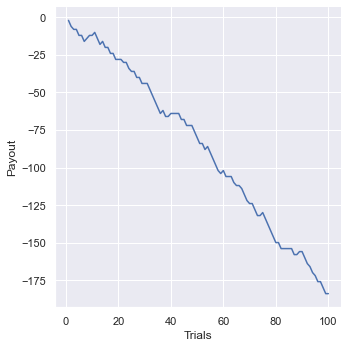

In [436]:
print(simulation(100, 8, 2))


In [492]:
def EV(bet):
    totalEV = 0
    for i in range(1, 7):
        if bet == 1:
            p = getPorbability(i)
        else:
            p = getPorbability(i + bet)
        facePair = p['One Face Pair']
        numberPair = p['One Number Pair']
        noPair = p['No Pairs']
        pairFaceNumber = p['Both Face & Number Pair']
        if bet == 1:
            ev = noPair * bet + facePair * (bet - FACE_PAYOUT) + numberPair * (bet - NUMBER_PAYOUT) + pairFaceNumber * (bet - FACE_PAYOUT)
        else:
            ev = noPair * bet + facePair * (bet - FACE_PAYOUT) + numberPair * (bet - NUMBER_PAYOUT) + pairFaceNumber * (bet - FACE_NUMBER_PAYOUT)
        totalEV += (1 / 6) * ev

    return totalEV


In [493]:
EV(1)

0.287710625985255

In [490]:
EV(2)

0.4547057009667882

In [491]:
EV(3)

0.9986753866267079

In [494]:
def probabilityOfPairOld(cardsDrawn):
    nFaceCards = 3 * 4
    nWaysTotal = choose(52, cardsDrawn)

    nNoPair = (choose(13, cardsDrawn) * (choose(4, 1) ** cardsDrawn))
    pNoPair = nNoPair / nWaysTotal
    pAtLeastOnePair = 1 - (nNoPair / nWaysTotal)

    #NP - Includes number pairs
    nOneFaceNP = choose(nFaceCards, 1) * choose(52 - nFaceCards, cardsDrawn - 1)
    if (cardsDrawn > 1):
        nTwoFaceNP = choose(3, 2) * (choose(4, 1) ** 2) * choose(52 - nFaceCards, cardsDrawn - 2)
        if (cardsDrawn > 2):
            nThreeFaceNP = (choose(4, 1) ** 3) * choose(52 - nFaceCards, cardsDrawn - 3)
        else:
            nThreeFaceNP = 0
    else:
        nTwoFaceNP = 0
        nThreeFaceNP = 0
    nNoFaceNP = choose(52 - nFaceCards, cardsDrawn)
    pAtLeastOneFacePair = 1 - ((nNoFaceNP + nOneFaceNP + nTwoFaceNP + nThreeFaceNP) / nWaysTotal) #allows for number pairs


    nNoNumber = 0
    for i in range(1, cardsDrawn + 1):
        nNoNumber += choose(nFaceCards, i) * (choose(10, cardsDrawn - i) * (math.pow(choose(4, 1), (cardsDrawn - i))))
    
    nNoFace = choose(10, cardsDrawn) * (math.pow(choose(4, 1), (cardsDrawn)))


    pAtLeastOneNumberPair = 1 - (nNoFace + nNoNumber) / nWaysTotal # all for face pairs


    return {'One Face Pair': pAtLeastOneFacePair, 'One Number Pair': pAtLeastOneNumberPair, 'No Pairs': pNoPair, 'Both Face & Number Pair': pAtLeastOneFacePair * pAtLeastOneNumberPair}